# A homework on mulitway fixed effect approach

[Download notebook :fontawesome-solid-download:](../hw-twfe.ipynb){: .md-button .md-button--primary download="hw-twfe.ipynb"}

In this homework we are going to consider a fictuous grading at a given universities and try to see what we can learn from grade variability and it affects earnings.

In the first data set we have the grades collected by a bunch of student within a given summester. Each student attended 2 courses. From this data we are going to try to extrac the ability of each student while allowing for course specific intercept. We can then use this to evaluate how much of the grade variation is due to student differences versus course differences and other factors (residuals). 

Given this ability measures, we then merge a second file which has the earnings of the student at age 35. We then evaluate the effect of academic ability on individual earnings. Here again we will worry about the effect of over-fitting.

Of course this requires, like we saw in class, estimating many parameters, hence we will look into overfitting and how to address it! We wil lmake use of sparse matrices, degree of freedom correction and bias correction.

The two data files you will need are:

 - grades: [hw4-grades.json](http://econ21340.lamadon.com/hw4-grades.json)
 - earnings: [hw4-earnings.json](http://econ21340.lamadon.com/hw4-earnings.json)

Useful links:
 - [Sparse linear solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html)

In [155]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.sparse.linalg import spsolve, inv
from scipy.sparse import csc_matrix, hstack
import statsmodels.formula.api as smf

In [156]:
%cd ..
%load_ext autoreload
%autoreload 2
#import solutions.sol_pset4 as solution # you need to command this, you don't have the solution file!
#solution.simulate_data()

/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explaining the dispersion in grades

Load the grade data from `hw4-grades.json`. Then compute:

 1. total variance in grades
 2. the between class variance
 3. plot the histogram of class size

In [157]:
file_grades = os.path.expanduser("~/Downloads/hw4-grades.json")

grades = pd.read_json(file_grades, lines=True,
                     dtype={'grade': float,
                            'class_id': str,
                            'student_id': int,
                            'major': str,
                            'firstname': str})

In [158]:
def question1(df):
    
    # 1.1: calculate variance in grades 
    total_var = df.var()['grade']

    # 1.2: calculate the between class variance
    class_means = df.groupby("class_id").agg('mean')['grade']
    df_merge = df.merge(class_means, how = "left", on = "class_id")
    class_var = df['grade'].var()
    
    # Print both variances 
    print('total variance is {}'.format(total_var))
    print('between class variance is {}'.format(class_var))

    # 1.3: plot histogram of class size 
    class_sizes = df.groupby('class_id').agg('count')['grade']
    plt.hist(class_sizes)
    plt.grid(b=True, which='major', linestyle='-')
    
    return df 


total variance is 2.1999202001732217
between class variance is 2.1999202001732217
6732 students and 673 classes


,grade,class_id,student_id,major,firstname
0,0.843900,GP8471,9,PHYSICAL AND HEALTH EDUCATION TEACHING,Leann
1,0.926570,IK1731,9,PHYSICAL AND HEALTH EDUCATION TEACHING,Leann
2,1.695413,GW2045,15,STUDIO ARTS,Marcus
3,-0.038370,ML7772,15,STUDIO ARTS,Marcus
4,2.129442,BI3547,22,MANAGEMENT INFORMATION SYSTEMS AND STATISTICS,Lonnie
...,...,...,...,...,...
13459,-2.318588,JE6164,49527,PUBLIC POLICY,Lea
13460,-1.458787,GQ0531,49534,PHYSICS,Leonard
13461,-1.560250,IX0276,49534,PHYSICS,Leonard
13462,2.091195,KX3268,49539,EARLY CHILDHOOD EDUCATION,Addie


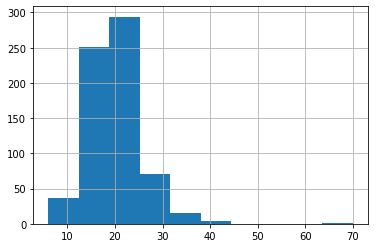

In [159]:
df_all = question1(grades)

ns = len(np.unique(df_all['student_id']))
nc = len(np.unique(df_all['class_id']))
nn = len(df_all)

print("{} students and {} classes".format(ns,nc))

df_all[["grade","class_id","student_id","major","firstname"]]

# Constructing the sparse regressor matrices

In a similar fashion to what we covered in the class we want to estimate a two-way fixed model of grates. Specifically, we are want to fit:

$$y_{ic} = \alpha_i + \psi_c + \epsilon_{ic}$$ 

where $i$ denotes each individual, $c$ denote each courses and $\epsilon_{ic}$ is an error term that will assume conditional mean independent of the assignment of students to courses.

We are going to estimate this using least-square. This requires that we construct the matrices that correspond to the equation for $y_{ic}$. We then want to consruct the $A$ and $J$ such that 

$$Y = A \alpha + J \psi + E$$ 

where for $n_s$ students each with $n_g$ grades in difference courses and a total of $n_c$ courses we have that $Y$ is $n_s \cdot n_g \times 1$ vector, $A$ is a $n_s \cdot n_g \times n_s$ matrix and $J$ is $n_s \cdot n_g \times n_c$. $\alpha$ is the vector of size $n_s$ and $\psi$ is a vector of size $n_c$.

Each fo the $n_s \cdot n_g$ correspond to a grade, in each row $A$ has a $1$ in the column corresponding to the individual of this row. Similary, $J$ has a $1$ for for the column corresponding to the class of that row.

So, I ask you to:

 1. construct these matrices using python sparse matrices `scipy.sparse.csc.csc_matrix`


In [160]:
ns = len(np.unique(df_all['student_id']))
nc = len(np.unique(df_all['class_id']))
nn = len(df_all)

def question2(df):
   
    # Construct matrix Y: ns⋅ng×1 
    data = df['grade']
    row_ind = np.asarray([i for i in range(nn)])
    col_ind = np.asarray([0 for i in range(nn)])
    Y = csc_matrix((data, (row_ind, col_ind)), shape = (nn, 1))
    
    # Construct matrix A: ns⋅ng×ns
    data = np.asarray([1 for i in range(nn)])
    row_ind = np.asarray([i for i in range(nn)])
    col_ind = [i for i in range(ns) for j in (0,1)]
    A = csc_matrix((data, (row_ind, col_ind)), shape = (nn, ns))
    
    # Construct matrix J: ns⋅ng×nc
    class_ids = df['class_id'].sort_values().unique()
    class_ids = pd.DataFrame(class_ids, columns = ['class_id'])

    data = np.asarray([1 for i in range(nn)])
    row_ind = np.asarray([i for i in range(nn)])
    col_ind = [class_ids[class_ids['class_id']==i].index.item() for i in df['class_id']]
    J = csc_matrix((data, (row_ind, col_ind)), shape = (nn, nc))
    
    return Y, A, J

<class 'scipy.sparse.csc.csc_matrix'>
(13464, 6732)
(13464, 673)
(13464, 1)
13464
13464


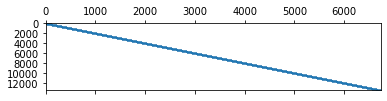

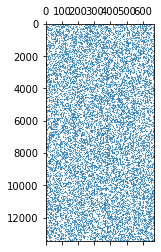

In [161]:
Y,A,J = question2(df_all)

print(type(A))
print(A.shape)
print(J.shape)
print(Y.shape)
print(A.sum())
print(J.sum())

# getting a nice diagonal here requires sorting by the studend_id
plt.spy(A,aspect=0.1,markersize=0.2)
plt.show()
plt.spy(J,aspect=0.1,markersize=0.2)
plt.show()

# Estimating the model

Next we estimate our model using the OLS estiamtor formula. We first remove the last column of $J$ (since the model we wrote does not pin down a constant we force the last course to have $\psi=0$). Solve the linear system using the formula

$$ \hat{\gamma} = (M'M)^{-1} M' Y $$

where $M = [A,J]$ and $\gamma = (\alpha,\psi)$.

So do the following:

 1. select the last column simply by doing `J = J[:,1:(nc-1]]`
 2. use `scipy.sparse.hstack` to concatenate the matrices to create M
 3. use `scipy.sparse.linalg.spsolve` to solve a sparse linear system
 4. extract $\hat{\alpha}$ from $\hat{\gamma}$ by selecting the first $n_s$ terms 
 5. merge $\hat{\alpha}$ into `df_all`
 6. compute the variance of $\hat{\alpha}$ in `df_all`
 7. compute the variance of the residuals
 8. What share of the total variation in grades can be attributed to difference in students?


In [162]:
def question3(df,A,J,Y):
    
    #3.1 Select the column J
    J = J[:,1:(nc-1)]
    
    #3.2 Concatenate the matrices to create M
    M = hstack([A,J])
    
    #3.3.1 Transpose the resultant matrix M
    M_inv = M.transpose()
    
    #3.3.2 Inverse the product of M with its tranpose
    M_M_inv = M_inv * M
    M_inv_Y = M_inv * Y
    
    #3.3.3 Solve the sparse linear system
    #The matrix M_M_inv represents the right hand side of the equation
    gamma = spsolve(M_M_inv, M_inv_Y)
    
    #3.4 Extract alpha_hat from gamma_hat
    #Select the first ns terms
    alpha = gamma[0:ns]
    
    #3.5 Merge alpha into df_all
    #3.5.1 Sort df_all by unique student ids
    students = df['student_id'].unique()
    
    #3.5.2 Create new data frame with alpha and student ids
    df_alpha = pd.DataFrame(alpha)
    df_alpha=df_alpha.rename(columns = {0: 'alpha_hat'})
    
    df_students = pd.DataFrame(students)
    df_students = df_students.rename(columns = {0: 'student_id'})
    
    df_alpha_students = pd.concat([df_alpha, df_students], axis = 1)
    
    #3.5.2 Merge
    df_local = df.copy()
    df_local = df_local.merge(df_alpha_students, how = 'left', left_on = 'student_id', right_on = 'student_id')
    
    #3.6 Compute the variance of alpha in df_all
    alpha_var = df_local['alpha_hat'].var()
    
    #3.7.1 Construct the residuals based on our OLS estiamtor formula
    #The estimated value is gamma . M where: M=[A,J]
    estimate = M * gamma
    df_local['resid'] = df_local['grade'] - estimate
    
    #3.7.2 Compute the variance of the residuals
    residuals_var = df_local['resid'].var()
    
    #3.8 Share of the total variation in grades can be attributed to difference in students
    grades_var = df_local['grade'].var()
    share_var = residuals_var/grades_var

    return df_local, M, gamma


In [163]:
df_all, M, gamma_hat = question3(df_all,A,J,Y)
print(df_all['alpha_hat'].var(),df_all['resid'].var(),df_all['grade'].var())
df_all[["grade","class_id","student_id","major","firstname","alpha_hat"]]

1.3362650061103234 0.24993167765745822 2.1999202001732217


,grade,class_id,student_id,major,firstname,alpha_hat
0,0.843900,GP8471,9,PHYSICAL AND HEALTH EDUCATION TEACHING,Leann,1.108694
1,0.926570,IK1731,9,PHYSICAL AND HEALTH EDUCATION TEACHING,Leann,1.108694
2,1.695413,GW2045,15,STUDIO ARTS,Marcus,0.253192
3,-0.038370,ML7772,15,STUDIO ARTS,Marcus,0.253192
4,2.129442,BI3547,22,MANAGEMENT INFORMATION SYSTEMS AND STATISTICS,Lonnie,1.706414
...,...,...,...,...,...,...
13459,-2.318588,JE6164,49527,PUBLIC POLICY,Lea,-1.773030
13460,-1.458787,GQ0531,49534,PHYSICS,Leonard,-0.663055
13461,-1.560250,IX0276,49534,PHYSICS,Leonard,-0.663055
13462,2.091195,KX3268,49539,EARLY CHILDHOOD EDUCATION,Addie,0.840739


####  3.8: What share of the total variation in grades can be attributed to difference in students?
The total variation in grades is 2.20, and the variation attributed to the difference in students is 1.33. Therefore, the share of the total variation in grades that can be attributed to the difference in students is 1.33/2.20 = 60%. 

# A simple evaluation of our estimator

To see what we are dealing with, we are simly going to re-simulate using our estimated parameters, then re-run our estimation and compare the new results to the previous one. This is in the spirit of a bootstrap exercise, onyl we will just do it once this time.

Please do:

 1. create $Y_2 = M \hat{\gamma} + \hat{\sigma}_r E$ where $E$ is a vector of draw from a standard normal.
 2. estimate $\hat{\gamma}_2$ from $Y_2$
 3. report the new variance term and compare them to the previously estimated
 4. comment on the results (not that because of the seed and ordering, your number doesn't have to match mine exactly)


In [164]:
def question4(df,M_matrix,gamma):
    
    #4.1 Re-simulate Y using our estimated parameters
    
    #M and gamma_hat are estimated in the previous problem
    #Draw E from a standard normal 
    #Using the standard deviation of the residuals from our previous estimation
    residuals_var=df['resid'].var()
    Y_new = M_matrix * gamma + np.random.normal(size = nn)*np.sqrt(residuals_var)
    
    #4.2 Re-run the estimation
    M_inv=M_matrix.transpose()
    
    M_M_inv=M_inv*M_matrix
    M_inv_Y=M_inv*Y_new
    
    #Estimate new gamma_hat from Y_new
    gamma_new=spsolve(M_M_inv, M_inv_Y)
    alpha_new=gamma_new[0:ns]
    
    #4.3 Report the new variance term
    
    #4.3.1 Create new data frame with alpha and student ids
    
    students=df['student_id'].unique()
    df_alpha = pd.DataFrame(alpha_new)
    df_alpha=df_alpha.rename(columns={0: 'alpha_hat2'})
    
    df_students = pd.DataFrame(students)
    df_students=df_students.rename(columns={0: 'student_id'})
    
    df_alpha_students=pd.concat([df_alpha, df_students], axis=1)
    
    #4.3.2 Merge
    df_local2=df.copy()
    df_local2 = df_local2.merge(df_alpha_students, how='left', left_on='student_id', right_on='student_id')
    
    #4.3.3 Compute the variance of alpha in df_all
    alpha_var2=df_local2['alpha_hat2'].var()
    
    #4.3.4 Construct the residuals based on our OLS estiamtor formula
    #The estimated value is gamma . M where: M=[A,J]
    estimate2=M_matrix*gamma_new
    df_local2['resid2']=Y_new-estimate2
    
    #3.7.2 Compute the variance of the residuals
    residuals_var=df_local2['resid2'].var()
    
    return df_local2

In [165]:
df_all = question4(df_all,M,gamma_hat)
df_all['alpha_hat2'].var(),df_all['resid2'].var()

(1.4703210132861886, 0.11222277379891199)

####  4.4: comment on the results (note that because of the seed and ordering, your number doesn't have to match mine exactly)
This exercise was a bootstrap-esque estimation where we re-simulated the parameters and estimated a new alpha hat 2. The variance of the new alpha hat 2 is 1.47, which is larger than the variance of alpha hat in the previous question, 1.3. Additionally, the variance of the new residuals is 0.11, which is also smaller than the variance of the residuals in the previous problem, 0.25. These results are interesting becaue the variance of the new alpha hat estimator increased, but the variance new residuals decrease. This could be a sign of overfitting, because the decrease in variance of the residauls occured from just one resimulation and reestimation.  

Noticed how even the variance of the residual has shrunk? Now is the time to remember STATS 101. We have all heard this thing about degree of freedom correction! Indeed we should correct our raw variance estimates to control for the fact that we have estimated a bunhc of dummies. Usually we use $n/n-1$ because we only estimate one mean. Here however we have estimated $n_s +n_c - 1$ means! Hence we should use 

$$ \frac{N}{N-n_s -n_c +1} \hat{Var}(\hat{\epsilon}) $$

please do:

 1. compute this variance corrected for degree of freedom using your recomputed residuals 
 2. compare this variance to the variance you estimated in quetion 3
 3. what does this suggest about your estimates in Q3?

In [166]:
def question4b(df):
    
    #4b.1.1 Compute the degrees of freedom
    dof=nn/(nn - ns - nc + 1)
    
    #4b.1.2 Compute the variance corrected for degree of freedom
    #Using the newly computed residuals from the dataframe
    residuals_var_corrected=(df['resid2'].var())*dof
    
    print('Var2 with degree of freedom correction:{}'.format(residuals_var_corrected))

In [167]:
question4b(df_all)

Var2 with degree of freedom correction:0.2493345588165926


#### 4b.2: compare this variance to the variance you estimated in question 3
This new corrected variance of 0.249 is very similar to the variance we estimated in question 3 of 0.250.

#### 4b.3: what does this suggest about your estimates in Q3?
This suggests that the estimates in question 3 are likely to be more accurate than the estimates we found in question 4, since they match the estimate for variance after we corrected for degrees of freedom. This also suggests that the degree of freedom correction is necessary when resimulating and reestimating the variance.

# Evaluate impact of academic measure on earnings 

In this section we load a separate data set that contains for each student their earnings at age 35. We are intereted in the effect of $\alpha$ on earnings. 

Do the following:

 1. load the data the earnings data listed in the intro
 2. merge $\alpha$ into the data
 3. regress earnings on $\alpha$.

In [168]:
#5.1 Loading the json files with the earnings data listed in the intro
file_earnings = os.path.expanduser("~/Downloads/hw4-earnings.json")

earnings = pd.read_json(file_earnings, lines=True,
                     dtype={'grade': float,
                            'class_id': str,
                            'student_id': int,
                            'major': str,
                            'firstname': str})

In [169]:
def question5(df):
    
    #5.2 Merge alpha into the data
    df_alpha = df[['student_id', 'alpha_hat']]
    df_merge = earnings.merge(df_alpha, how='left', on='student_id')
    df_merge = df_merge.drop_duplicates().reset_index(drop=True)

    #Regress earnings on alpha
    regression = smf.ols('earnings ~ alpha_hat', data = df_merge).fit()
    
    print(regression.summary())
    
    return df_merge

In [170]:
df_earnings = question5(df_all)
df_earnings

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     173.0
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           5.05e-39
Time:                        05:17:28   Log-Likelihood:                -9594.9
No. Observations:                6732   AIC:                         1.919e+04
Df Residuals:                    6730   BIC:                         1.921e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0324      0.012     -2.634      0.0

,student_id,major,firstname,earnings,alpha_hat
0,9,PHYSICAL AND HEALTH EDUCATION TEACHING,Leann,-1.498308,1.108694
1,15,STUDIO ARTS,Marcus,2.908033,0.253192
2,22,MANAGEMENT INFORMATION SYSTEMS AND STATISTICS,Lonnie,0.933555,1.706414
3,24,MISCELLANEOUS FINE ARTS,Seamus,-0.913896,-1.118323
4,35,MEDICAL ASSISTING SERVICES,Wilbert,0.545178,1.461359
...,...,...,...,...,...
6727,49520,ANIMAL SCIENCES,Amos,-1.723242,0.807726
6728,49525,COMMERCIAL ART AND GRAPHIC DESIGN,Isaac,1.264385,0.102995
6729,49527,PUBLIC POLICY,Lea,-0.368899,-1.773030
6730,49534,PHYSICS,Leonard,1.244166,-0.663055


# Bias correction - construct the Q matrix

We want to apply bias correction to refine our results. As we have seen in class thaqt we can directly compute the bias of the expression of interest.

$$ E[ \hat{\gamma} Q \hat{\gamma}' ] = \gamma Q \gamma + \frac{\sigma^2}{n} \text{Tr}[ ( M'M )^{-1} Q] $$

under homoskedatic assumption of the error and hence we get the following expresison for the bias for any $Q$ matrix:

$$ B = \frac{\sigma^2}{N} \text{Tr}[ ( M'M )^{-1} Q] $$

When computing the variance of the measured ability of the student, we simply use a diagonal matrix on $\gamma$ which selects only the ability part and removes the average. 

do:
 1. Construct such Q matrix.
 2. check that $\gamma Q \gamma' = \hat{Var}(\hat{a})$.

In [171]:
def question6(ns, nc):
    diag = np.eye(ns)
    n = np.full((ns, ns), ns)
    Q = diag - 1/n
    zeros = np.full((ns, nc - 2), 0)
    zeros2 = np.full((nc - 2, ns + nc -2), 0)

    Q2 = np.append(Q, zeros, axis = 1)
    Q3 = np.append(Q2, zeros2, axis = 0)
    
    return Q3

In [172]:
# a small example if we had ns=5,nc=4
Qbis = question6(ns=5,nc=4)
print(Qbis)

# the full Q
Q = question6(ns,nc)

# comparing Q expression to df_all expression
1/(ns)*np.matmul( gamma_hat, np.matmul(Q,gamma_hat )), gamma_hat[range(ns)].var()

[[ 0.8 -0.2 -0.2 -0.2 -0.2  0.   0. ]
 [-0.2  0.8 -0.2 -0.2 -0.2  0.   0. ]
 [-0.2 -0.2  0.8 -0.2 -0.2  0.   0. ]
 [-0.2 -0.2 -0.2  0.8 -0.2  0.   0. ]
 [-0.2 -0.2 -0.2 -0.2  0.8  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]]


(1.3361657588579536, 1.3361657588579536)

# Bias correction - Variance share

We are now finally in the position to compute our bias. We have are matrix $Q$. Now we also need the variance of the residual! Given what we have learn in Question 4, we definitely want to use the formula with degree of freedom correction.

1. Compute $\sigma^2_r$ with the degree of freedom correction
2. Invert $M'M$ using `scipy.sparse.linalg`
3. Compute $B = \frac{\sigma^2}{N} \text{Tr}[ ( M'M )^{-1} Q]$ using `np.trace`
4. Remove this from original estimate to get the share of variance explained by student differences!

Note that inversing a matrix is far longer than solving a linear system. You might need to be patient here!


In [173]:
def question7(M, Q, df_all):
    # 7.1:  Compute  𝜎2𝑟  with the degree of freedom correction
    var = df_all['resid'].var()
    dof_correction = nn / (1 - ns - nc + nn)
    var = dof_correction * var

    # 7.2: Invert M'M using `scipy.sparse.linalg`
    MpM_inv = inv(M.transpose() * M)

    # 7.3: Compute  𝐵=𝜎2𝑁Tr[(𝑀′𝑀)−1𝑄]  using np.trace
    B = (eps_var2/(nn/2)) * np.trace(MpM_inv*Q)
    
    return B

In [174]:
B = question7(M,Q,df_all)
B

/Applications/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:310: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


0.3082431433013275

In [175]:
gamma_hat[range(ns)].var() - B

1.0279226155566261

# Bias correction - Regression coefficient

Finally, we look back at our regression of earnings on estimated academic ability. We have seen in class that when the regressor has measurment error this will suffer from attenuation bias. Here we now know exactly how much of the variance is noise thanks to our bias correction.

The attenuation bias is given by :

$$ \beta_2 = \frac{Var(x)}{Var(x) + B} \beta $$

We then decide to compute a correction for our regression using our estimated $B$. This means computing a corrected parameters as follows:

$$ \hat{\beta}^{BC} = \frac{Var(x) + B}{Var(x)} \hat{\beta}^{Q5} = \frac{Var(\hat{\alpha})}{Var(\hat{\alpha})-B} \hat{\beta}^{Q5} $$


Do:

 1. compute the corrected $\hat{\beta}^{BC}$
 2. FIY, the true $\beta$ I used to simulate the data was **0.2**, is your final parameter far? Is is economically different from the $\hat{\beta}^{Q5}$ we got in Question 5?
 

In [176]:
# Find beta from question 5
df_alpha = df_all[["student_id", "alpha_hat"]]
df_merge = earnings.merge(df_alpha, how='left', on='student_id')
df_merge = df_merge.drop_duplicates().reset_index(drop=True)
regression = smf.ols('earnings ~ alpha_hat', data = df_merge).fit()
beta_q5 = regression.params[1]

# Find variance of alpha_hat
var_ahat = df_all['alpha_hat'].var()

# Compute corrected beta
new_beta = (var_ahat / (var_ahat - B)) * beta_q5
new_beta

0.18141251701776565

In [177]:
beta_q5

0.13956515573533984

#### 8.2: FIY, the true $\beta$ I used to simulate the data was **0.2**, is your final parameter far? Is is economically different from the $\hat{\beta}^{Q5}$ we got in Question 5?

The corrected beta we calculated is 0.18, which is very close to the true parameter of 0.2. The corrected beta also seems to be economically different from the beta estimate from question 5, which was 0.14. After correcting for attenuation bias, the coefficient on the impact of grades on earnigns was 0.29% higher, which shows a much stronger role that academics play on future earnings than our previous estimate that did not correct for attenuation bias. This also makes sense because in class, we learned that direction attenuation bias was always towards zero, and since we have a positive estimate, attenuation bias would direct us toward a smaller estimate. 


# Conclusion

I hope you have learned about the pitfalls of over-fitting in this assignment! There are many and they can drastically affect the results and the conclusion of an empirical analysis. 

This is the end of the class, I hope you enjoyed it and that you learned a thing or two, have a nice Christmas!